In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import compute_speed, compute_head_angle_to_pup, compute_distance_to_pup, plot_mouse_angle_to_pup

## Reading and loading data ##

In [2]:
data_dir = "data"
DL = DataLoader(data_dir)

Found items ['.DS_Store', 'MBI5335RR'] at directory data
Found items ['.DS_Store', 'MBI5335RR_240309_d6', 'MBI5335RR_240305_d2', 'MBI5335RR_240304_d1', 'MBI5335RR_240308_d5', 'MBI5335RR_240306_d3', 'MBI5335RR_240307_d4'] at directory data/MBI5335RR
Found items ['MBI5335RR_240309_d6_Avisoft', 'MBI5335RR_240309_d6_Behavior'] at directory data/MBI5335RR/MBI5335RR_240309_d6
Found items ['MBI5335RR_240309_d6_Avisoft_concatenated 2024-04-21  2_08 PM_Stats_SYNCCORRECTED.xlsx'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Avisoft
Found items ['MBI5335RR_d6DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.csv', 'MBI5335RR_240309_d6_BehavSummary.csv'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Behavior
Found items ['MBI5335RR_240305_d2_Behavior', 'MBI5335RR_240305_d2_Avisoft'] at directory data/MBI5335RR/MBI5335RR_240305_d2
Found items ['MBI5335RR_240305_d2_BehavSummary.csv', 'MBI5335RR_d2DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.

## Data Exploration ##

##### Day 1 trials #####

In [3]:
# get data for d1 experiment
day1_data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = "d1")

# fill out dataframes
df_summary = day1_data['Behavior']['df_summary']
df_DLC = day1_data['Behavior']['df_dlc']

<Axes: xlabel='pup_x'>

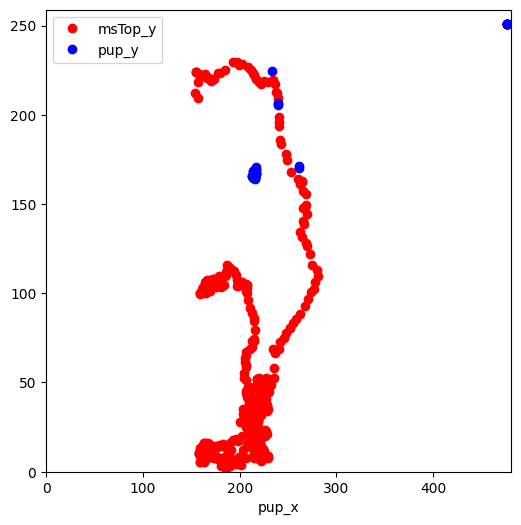

In [4]:
# create a grid of 1 x 2 plots
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ylim = max(df_DLC['msTop_y'].max(), df_DLC['pup_y'].max())
xlim = max(df_DLC['msTop_x'].max(), df_DLC['pup_x'].max())

# color the points with the time
df_DLC.iloc[1000:1500].plot(x='msTop_x', y='msTop_y', style='o', ax=ax, xlim=(0, xlim), ylim=(0, ylim), color = 'r')
df_DLC.iloc[1000:1500].plot(x='pup_x', y='pup_y', style='o', ax=ax,xlim=(0, xlim), ylim=(0, ylim), color = 'b')


In [5]:
df_summary.head(3)
# find dtype of each column
#df_summary.dtypes

,Group,AnimalID,ExptID,TrialNum,PupDisplPosition,BehavRecdTrialStartSecs,BehavRecdTrialEndSecs,PupDispDropSecs,MouseFirstPickUpPupSecs,DropPupNestSecs,TrialDesignAchieved,EndHabituation,OptoUsed,OptoStartSecs,OptoEndSecs,Features,Notes
0,M,MBI5335RR,d1,1,2,362.042,384.586,369.082,382.266,384.586,1,273.378,0,0,0,0,0
1,M,MBI5335RR,d1,2,3,390.098,402.842,396.698,399.682,402.842,1,273.378,0,0,0,0,0
2,M,MBI5335RR,d1,3,1,411.082,494.930,415.186,491.418,494.930,1,273.378,0,0,0,0,0


In [6]:
df_DLC.head(3)
#df_DLC["time_seconds"]*30

,frame_index,time_seconds,msTop_x,msTop_y,msTop_likelihood,endHeadbar_x,endHeadbar_y,endHeadbar_likelihood,earRight_x,earRight_y,...,tailBase_likelihood,nose_x,nose_y,nose_likelihood,centerNest_x,centerNest_y,centerNest_likelihood,pup_x,pup_y,pup_likelihood
151,151,5.033333,170.865509,89.811813,0.961542,190.735977,79.387955,0.943847,174.400299,80.521759,...,0.811119,169.054947,96.152382,0.965620,204.863220,57.566437,0.910896,477.403198,251.108810,0.074489
152,152,5.066667,170.884583,89.919662,0.960909,190.975998,79.499725,0.941302,174.574753,80.326324,...,0.806345,168.950119,96.181671,0.965517,204.960968,57.520256,0.904566,477.380341,251.101379,0.074293
153,153,5.100000,170.883240,90.323051,0.961621,191.376846,80.730232,0.936073,174.205078,80.630722,...,0.751888,169.327026,96.632072,0.967170,205.155075,57.570263,0.890773,477.362000,251.079193,0.073658


## Feature Extraction ##

### BehavSummary + DLC  ###

- **BehavSummary + DLC**
    - Define behavioral windows (e.g: -2 to +2 seconds of each behavioral event)
    - Define behavioral windows pre-event (e.g: -x to 0 seconds of each behavioral event)
    - Find behavioral events (from BehavSummaries; *timing info*) in the DLC position data (*x,y info*):
        - at each behavioral event, where was the mouse and the pup located in the arena?
            - how far was the mouse from the pup?
            - what was the head direction of the mouse (towards the pup) at that point?
            - ‘approach’ trajectory: parse out trajectory of mouse towards pup and try to find a segment which is more ‘direct’/ higher speed
        - For the pre-event behavioral window of MouseFirstPickUpSecs: what is the speed of the mouse? What is the head direction of the mouse?

In [7]:
trial_1 = df_summary[df_summary['TrialNum'] == 1]

trial_1

BehavRecdTrialEndSecs = trial_1['BehavRecdTrialEndSecs'].values[0]
PupDispDropSecs = trial_1['PupDispDropSecs'].values[0]
MouseFirstPickUpPupSecs = trial_1['MouseFirstPickUpPupSecs'].values[0]
DropPupNestSecs = trial_1['DropPupNestSecs'].values[0]
 
 # print all the times
print(BehavRecdTrialEndSecs, "frame index", BehavRecdTrialEndSecs*30, "int index", round(BehavRecdTrialEndSecs*30))
print(PupDispDropSecs, "frame index", PupDispDropSecs*30,"int index", round(PupDispDropSecs*30))
print(MouseFirstPickUpPupSecs, "frame index", MouseFirstPickUpPupSecs*30,"int index", round(MouseFirstPickUpPupSecs*30))
print(DropPupNestSecs, "frame index", DropPupNestSecs*30,"int index", round(DropPupNestSecs*30))

# compute frame indices by rounding
BehavRecdTrialEndSecs_frame = round(BehavRecdTrialEndSecs*30)
PupDispDropSecs_frame = round(PupDispDropSecs*30)
MouseFirstPickUpPupSecs_frame = round(MouseFirstPickUpPupSecs*30)
DropPupNestSecs_frame = round(DropPupNestSecs*30)

384.586 frame index 11537.58 int index 11538
369.082 frame index 11072.46 int index 11072
382.266 frame index 11467.980000000001 int index 11468
384.586 frame index 11537.58 int index 11538


In [8]:
# 2s is 60 frames
window_size = 60
start_frame_window = BehavRecdTrialEndSecs_frame - window_size
end_frame_window = BehavRecdTrialEndSecs_frame

# print corresponding time in minutes
print("Start time in seconds:", str(datetime.timedelta(seconds=start_frame_window/30)))
print("End time in seconds:", str(datetime.timedelta(seconds=end_frame_window/30)))

# look at the dataframe with frame_index within in the window
mask = (df_DLC['frame_index'] >= start_frame_window) & (df_DLC['frame_index'] <= end_frame_window)
trial_1_DLC = df_DLC[mask]

Start time in seconds: 0:06:22.600000
End time in seconds: 0:06:24.600000


<Axes: xlabel='pup_x'>

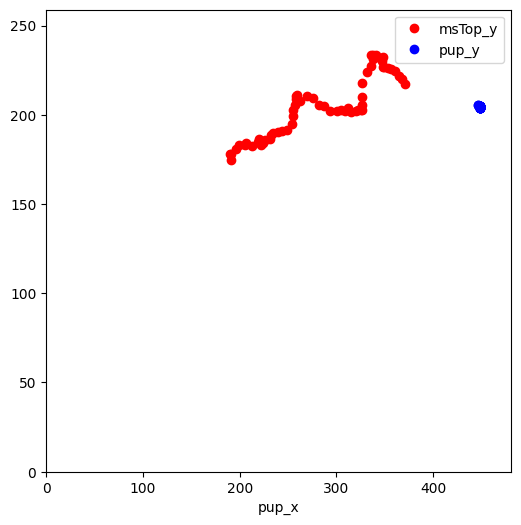

In [9]:
# plot mouse and pup positions
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

xlim, ylim =  max(df_DLC['msTop_x'].max(), df_DLC['pup_x'].max()), max(df_DLC['msTop_y'].max(), df_DLC['pup_y'].max())

trial_1_DLC.plot(x='msTop_x', y='msTop_y', style='o', ax=ax, xlim=(0, xlim), ylim=(0, ylim), color = 'r')
trial_1_DLC.plot(x='pup_x', y='pup_y', style='o', ax=ax,xlim=(0, xlim), ylim=(0, ylim), color = 'b')

Speed

Max speed: 241.5519362383066 Frame index: 11520 Time in minutes: 0:06:24


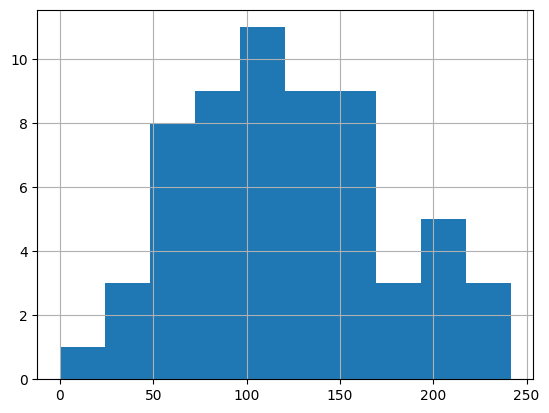

In [10]:
trial_1_DLC = compute_speed(trial_1_DLC)

# histogram of speed
trial_1_DLC['speed_cm/s'].hist()

# find point at which max speed is reached
max_speed = trial_1_DLC['speed_cm/s'].max()
max_speed_index = trial_1_DLC['speed_cm/s'].idxmax()

# find frame index and actual time in minutes
max_speed_frame_index = trial_1_DLC.loc[max_speed_index, 'frame_index']
max_speed_time = trial_1_DLC.loc[max_speed_index, 'time_seconds']
print("Max speed:", max_speed, "Frame index:", max_speed_frame_index, "Time in minutes:", str(datetime.timedelta(seconds=max_speed_time)))

Distance to pup

<Axes: >

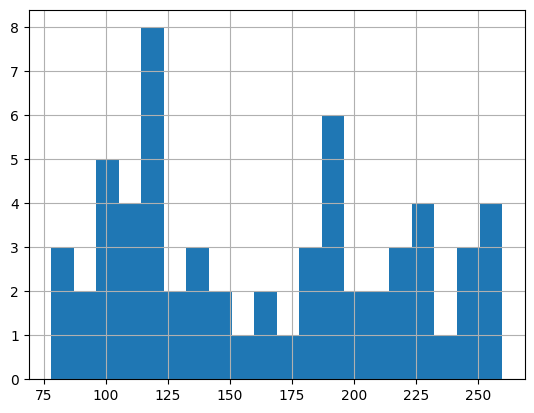

In [11]:
trial_1_DLC = compute_distance_to_pup(trial_1_DLC)

trial_1_DLC["distance_to_pup"].hist(bins=20)

Head angle to pup

<Axes: >

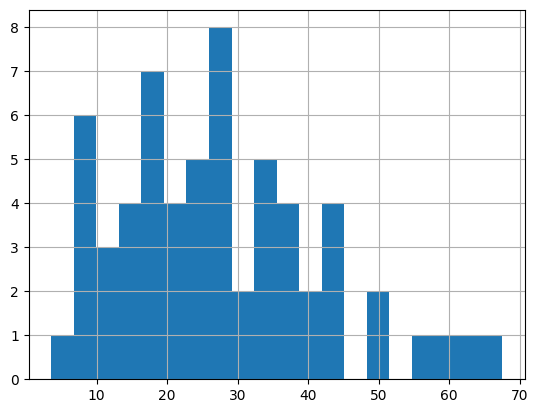

In [12]:
trial_1_DLC = compute_head_angle_to_pup(trial_1_DLC, add_vector_columns = True)

trial_1_DLC["head_angle_to_pup_degrees"].hist(bins=20)

Visualize head angle to pup

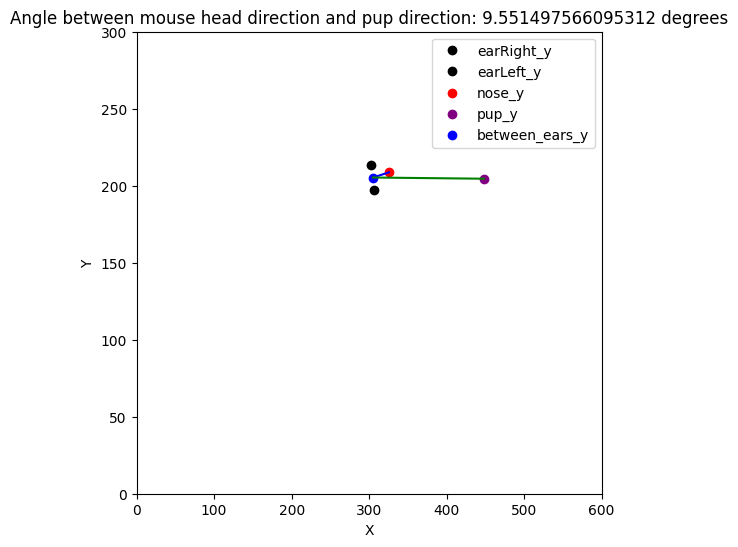

In [13]:
plot_mouse_angle_to_pup(trial_1_DLC, ylim = 300 , xlim = 600)

Process full file (df_DLC)

In [17]:
def extract_base_parameters(df_DLC, df_summary):

    # for each trial, get the start and end frames
    end_times, start_times, trial_nums = df_summary['BehavRecdTrialEndSecs'], df_summary['PupDispDropSecs'], df_summary['TrialNum']

    # create NaN columns for speed, distance to pup and head angle to pup
    df_DLC['speed_cm/s'] = np.nan
    df_DLC['distance_to_pup'] = np.nan
    df_DLC['head_angle_to_pup_degrees'] = np.nan

    # iterate over each trial
    for end, start, trial_num in zip(end_times, start_times, trial_nums):
            # compute frame indices
            end_frame, start_frame = round(end*30), round(start*30)

            print(f"Processing trial {trial_num} Start frame: {start_frame} End frame: {end_frame}")

            # get the data for the trial
            mask = (df_DLC['frame_index'] >= start_frame) & (df_DLC['frame_index'] <= end_frame)
            trial_DLC = df_DLC.loc[mask, :] 

            # compute speed
            trial_DLC = compute_speed(trial_DLC)
            # compute distance to pup
            trial_DLC = compute_distance_to_pup(trial_DLC)
            # compute head angle to pup
            trial_DLC = compute_head_angle_to_pup(trial_DLC)
            
            # update the dataframe
            df_DLC.loc[mask, :] = trial_DLC

    return df_DLC


In [18]:

df_DLC_updated = extract_base_parameters(df_DLC, df_summary)

Trial 1 Start frame: 11072 End frame: 11538
Trial 2 Start frame: 11901 End frame: 12085
Trial 3 Start frame: 12456 End frame: 14848
Trial 4 Start frame: 15232 End frame: 15940
Trial 5 Start frame: 16418 End frame: 19682
Trial 6 Start frame: 19972 End frame: 20270
Trial 7 Start frame: 20600 End frame: 20923
Trial 8 Start frame: 21386 End frame: 21866
Trial 9 Start frame: 22212 End frame: 24358
Trial 10 Start frame: 24884 End frame: 25584


In [16]:
df_DLC_updated

,frame_index,time_seconds,msTop_x,msTop_y,msTop_likelihood,endHeadbar_x,endHeadbar_y,endHeadbar_likelihood,earRight_x,earRight_y,...,nose_likelihood,centerNest_x,centerNest_y,centerNest_likelihood,pup_x,pup_y,pup_likelihood,speed_cm/s,distance_to_pup,head_angle_to_pup_degrees
151,151,5.033333,170.865509,89.811813,0.961542,190.735977,79.387955,0.943847,174.400299,80.521759,...,0.965620,204.863220,57.566437,0.910896,477.403198,251.108810,0.074489,NaN,NaN,NaN
152,152,5.066667,170.884583,89.919662,0.960909,190.975998,79.499725,0.941302,174.574753,80.326324,...,0.965517,204.960968,57.520256,0.904566,477.380341,251.101379,0.074293,NaN,NaN,NaN
153,153,5.100000,170.883240,90.323051,0.961621,191.376846,80.730232,0.936073,174.205078,80.630722,...,0.967170,205.155075,57.570263,0.890773,477.362000,251.079193,0.073658,NaN,NaN,NaN
154,154,5.133333,170.926773,90.564362,0.961369,191.282913,80.673759,0.933111,174.103851,80.784721,...,0.965332,208.330902,55.338409,0.897453,477.296814,251.060013,0.073508,NaN,NaN,NaN
155,155,5.166667,170.918793,90.485443,0.962388,191.297684,80.754738,0.930888,174.123138,80.792427,...,0.966048,209.248642,55.659248,0.909907,477.293640,251.065277,0.073560,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26036,26036,867.866667,209.939117,77.639259,0.145247,209.055069,75.931168,0.016676,210.217743,76.130127,...,0.009938,210.451965,71.425491,0.994742,480.212799,250.406647,0.063795,NaN,NaN,NaN
26037,26037,867.900000,207.269028,76.809303,0.025151,208.071136,76.504684,0.009770,209.278519,76.249054,...,0.005573,210.278320,68.849236,0.995682,480.212860,250.405945,0.064049,NaN,NaN,NaN
26038,26038,867.933333,208.179184,81.363785,0.282739,206.524475,80.659828,0.024828,208.075089,80.550095,...,0.021104,213.096329,72.999992,0.991961,480.213226,250.405502,0.064019,NaN,NaN,NaN
26039,26039,867.966667,209.563736,83.124634,0.252159,220.156143,78.939888,0.029228,208.904358,81.995323,...,0.023468,212.049164,73.347084,0.981267,480.216187,250.406601,0.063996,NaN,NaN,NaN
